In [2]:
from gvuln import *
import matplotlib.pyplot as plt
from time import time

torch.set_default_dtype(torch.float32)

# Differential Privacy

### No DP

In [3]:
compiledFile=compile2SOGA('DP_nonoise.soga')
cfg = produce_cfg(compiledFile)

output_dist = start_SOGA(cfg)

marg_nonoise = extract_marginal(output_dist, ['dataset[0]', 'avg'])

vdelta_nonoise = vdelta_bivariate_gaussian(marg_nonoise.gm.mu[0], marg_nonoise.gm.sigma[0], idx_o=1)
vgauss_nonoise = vgauss_bivariate_gaussian(marg_nonoise.gm.mu[0], marg_nonoise.gm.sigma[0], eps=1, idx_o=1)

gvd_nonoise = vdelta_nonoise.item()
gvg_nonoise = vgauss_nonoise.item()

gvd_nonoise, gvg_nonoise

(0.02102610468864441, 0.05263157933950424)

In [4]:
s_marg = extract_marginal(output_dist, ['dataset[0]'])
so_marg = extract_marginal(output_dist, ['dataset[0]', 'avg'])

entropy_nonoise = entropy_gaussian(s_marg.gm.mu[0], s_marg.gm.sigma[0])
cond_entropy_nonoise = cond_entropy_gaussian(so_marg.gm.mu[0], so_marg.gm.sigma[0], idx_o = [1])
mi_nonoise = mi_gaussian(marg_nonoise.gm.mu[0], marg_nonoise.gm.sigma[0], idx_o=[1])

print('Entropy of secret: ', entropy_nonoise)
print('Entropy of secret given output: ', cond_entropy_nonoise)
print('MI between secret and output: ', mi_nonoise)

Entropy of secret:  tensor(4.4147)
Entropy of secret given output:  tensor(4.3620)
MI between secret and output:  0.05268049240112305


In [5]:
compiledFile=compile2SOGA('DP_nonoise_obs.soga')
cfg = produce_cfg(compiledFile)

output_dist_obs = start_SOGA(cfg)

s_marg_obs = extract_marginal(output_dist_obs, ['dataset[0]'])

s_mu_obs = s_marg_obs.gm.mu[0]
s_sigma_obs = s_marg_obs.gm.sigma[0]
s_mu = s_marg.gm.mu[0]
s_sigma = s_marg.gm.sigma[0]

kl_nonoise = kl_div_gaussian(s_mu_obs, s_sigma_obs, s_mu, s_sigma)

print('KL divergence between secret given output value and secret: ', kl_nonoise)


KL divergence between secret given output value and secret:  0.007680241949856281


### Gaussian Mechanism

#### Black-box Estimation

In [6]:
def gaussian_dp_model(batch_size=10, std=5.):

    dataset = distributions.Normal(40., 20.).sample([batch_size, 10])

    avg = torch.mean(dataset, dim=1, keepdim=True)

    v = distributions.Normal(0., std).sample([batch_size, 1])

    return dataset[:, 0], avg + v

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
import numpy as np


Delta = 150/10
delta = 1/100
eps_list = torch.tensor([0.1, 0.5, 1., 2., 5., 10.])

gvuln_bbox = {}


for eps in eps_list:

    std = torch.sqrt(2*Delta**2*torch.log(torch.tensor(1.25/delta))/(eps**2))

    gvuln_bbox[eps.item()] = []

    for i in range(10):
    
        s_train, o_train = gaussian_dp_model(batch_size=1_000_000, std=std)
        s_test, o_test = gaussian_dp_model(batch_size=100_000, std=std)

        # Convert to numpy arrays if needed
        o_train_np = o_train.numpy() if hasattr(o_train, 'numpy') else np.array(o_train)
        s_train_np = s_train.numpy() if hasattr(s_train, 'numpy') else np.array(s_train)
        o_test_np = o_test.numpy() if hasattr(o_test, 'numpy') else np.array(o_test)
        s_test_np = s_test.numpy() if hasattr(s_test, 'numpy') else np.array(s_test)

        # Fit KNN regressor
        knn = KNeighborsRegressor(n_neighbors=100)
        knn.fit(o_train_np.reshape(-1, 1), s_train_np)  # reshape if o_train is 1D

        # Predict for test set
        s_pred = knn.predict(o_test_np.reshape(-1, 1))

        # Custom loss function (example: mean absolute error)
        def custom_loss(y_true, y_pred):
            return np.mean(np.exp(-0.5 * (y_true - y_pred) ** 2))

        loss = custom_loss(s_test_np, s_pred)

        gvuln_bbox[eps.item()].append(loss)

for key, list in gvuln_bbox.items():
    
    gvuln_bbox[key] = torch.tensor(list)

    print('Eps: ', key, 'Mean:', torch.mean(gvuln_bbox[key]), 'Std:', torch.std(gvuln_bbox[key]))


#### SOGA estimation

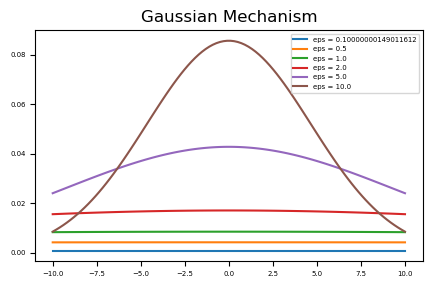

In [5]:
Delta = 150/10
delta = 1/100
eps_list = torch.tensor([0.1, 0.5, 1., 2., 5., 10.])

plt.figure(figsize=(5, 3))

for eps in eps_list:

    pars = {'std': torch.sqrt(2*Delta**2*torch.log(torch.tensor(1.25/delta))/(eps**2))}
    params_dict = {}
    for key, value in pars.items():
        params_dict[key] = torch.tensor(value.item(), requires_grad=True)    

    program = 'noise = gm([1.], [0.], [_std]);'
    compiledFile = compile2SOGA_text(program)
    cfg = produce_cfg_text(compiledFile)
    output_dist = start_SOGA(cfg, params_dict=params_dict)

    x = torch.linspace(-10, 10, 100).reshape(100, 1)
    y = output_dist.gm.pdf(x).detach().numpy()
    plt.plot(x, y, label='eps = {}'.format(eps))

plt.title('Gaussian Mechanism')
plt.legend(fontsize=5)
plt.tick_params(axis='x', labelsize=5)
plt.tick_params(axis='y', labelsize=5)


In [6]:
Delta = 150/10
delta = 1/100
eps_list = [0.1, 0.5, 1., 2., 5., 10.]

gvd_gauss = {}   # g-vulnerability for delta gain
gvg_gauss = {}   # g-vulnerability for Gaussian gain
entropy_gauss = {}       # entropy of the secret variable
cond_entropy_gauss = {}  # conditional entropy of secret given output
mi_gauss = {}            # mutual information between secret and output
kl_gauss = {}        # KL divergence between secret given output value and secret 

for eps in eps_list:

    print('Eps: ', eps)

    eps = torch.tensor(eps)

    compiledFile=compile2SOGA('DP_Gauss.soga')
    cfg = produce_cfg(compiledFile)

    pars = {'std': torch.sqrt(2*Delta**2*torch.log(torch.tensor(1.25/delta))/(eps**2))}
    params_dict = {}
    for key, value in pars.items():
        params_dict[key] = torch.tensor(value.item(), requires_grad=False)    

    print('std:', torch.sqrt(2*Delta**2*torch.log(torch.tensor(1.25/delta))/(eps**2)))

    output_dist = start_SOGA(cfg, params_dict=params_dict)

    marg_gauss = extract_marginal(output_dist, ['dataset[0]', 'avg'])
    s_marg_gauss = extract_marginal(output_dist, ['dataset[0]'])

    entropy_gauss['{}'.format(eps)] = entropy_gaussian(s_marg_gauss.gm.mu[0], s_marg_gauss.gm.sigma[0])
    cond_entropy_gauss['{}'.format(eps)] = cond_entropy_gaussian(marg_gauss.gm.mu[0], marg_gauss.gm.sigma[0], idx_o=[1])
    mi_gauss['{}'.format(eps)] = mi_gaussian(marg_gauss.gm.mu[0], marg_gauss.gm.sigma[0], idx_o=[1])
    gvd_gauss['{}'.format(eps)] =  vdelta_bivariate_gaussian(marg_gauss.gm.mu[0], marg_gauss.gm.sigma[0], idx_o=1).item()
    gvg_gauss['{}'.format(eps)] = vgauss_bivariate_gaussian(marg_gauss.gm.mu[0], marg_gauss.gm.sigma[0], eps=1, idx_o=1).item()

    compiledFile=compile2SOGA('DP_Gauss_obs.soga')
    cfg = produce_cfg(compiledFile)

    pars = {'std': torch.sqrt(2*Delta**2*torch.log(torch.tensor(1.25/delta))/(eps**2))}
    params_dict = {}
    for key, value in pars.items():
        params_dict[key] = torch.tensor(value.item(), requires_grad=False)    

    output_dist_obs = start_SOGA(cfg, params_dict=params_dict)

    s_marg_gauss_obs = extract_marginal(output_dist_obs, ['dataset[0]'])

    kl_gauss['{}'.format(eps)] = kl_div_gaussian(s_marg_gauss_obs.gm.mu[0], s_marg_gauss_obs.gm.sigma[0], s_marg_gauss.gm.mu[0], s_marg_gauss.gm.sigma[0])


Eps:  0.1
std: tensor(466.1267)
Eps:  0.5
std: tensor(93.2253)
Eps:  1.0
std: tensor(46.6127)
Eps:  2.0
std: tensor(23.3063)
Eps:  5.0
std: tensor(9.3225)
Eps:  10.0
std: tensor(4.6613)


In [7]:
print('G-Vulnerability (Delta Gain)')
for key in gvd_gauss.keys():
    print('\t Eps = {:.1f}, exact={:.6f}'.format(float(key), gvd_gauss[key]))

print('\n G-Vulnerability (Gauss Gain)')
for key in gvg_gauss.keys():
    print('\t Eps = {:.1f}, exact={:.6f}'.format(float(key), gvg_gauss[key]))

print('\n Conditional Entropy   ')
for key in cond_entropy_gauss.keys():
    print('\t Eps = {:.1f}, exact={:.6f}'.format(float(key), cond_entropy_gauss[key]))

print('\n Mutual Information   ')
for key in mi_gauss.keys():
    print('\t Eps = {:.1f}, exact={:.6f}'.format(float(key), mi_gauss[key]))

print('\n KL Divergence   ')
for key in kl_gauss.keys():
    print('\t Eps = {:.1f}, exact={:.6f}'.format(float(key), kl_gauss[key]))

G-Vulnerability (Delta Gain)
	 Eps = 0.1, exact=0.019947
	 Eps = 0.5, exact=0.019952
	 Eps = 1.0, exact=0.019965
	 Eps = 2.0, exact=0.020016
	 Eps = 5.0, exact=0.020269
	 Eps = 10.0, exact=0.020627

 G-Vulnerability (Gauss Gain)
	 Eps = 0.1, exact=0.049938
	 Eps = 0.5, exact=0.049949
	 Eps = 1.0, exact=0.049983
	 Eps = 2.0, exact=0.050109
	 Eps = 5.0, exact=0.050742
	 Eps = 10.0, exact=0.051634

 Conditional Entropy   
	 Eps = 0.1, exact=4.414661
	 Eps = 0.5, exact=4.414442
	 Eps = 1.0, exact=4.413766
	 Eps = 2.0, exact=4.411230
	 Eps = 5.0, exact=4.398658
	 Eps = 10.0, exact=4.381173

 Mutual Information   
	 Eps = 0.1, exact=0.000010
	 Eps = 0.5, exact=0.000229
	 Eps = 1.0, exact=0.000905
	 Eps = 2.0, exact=0.003441
	 Eps = 5.0, exact=0.016013
	 Eps = 10.0, exact=0.033498

 KL Divergence   
	 Eps = 0.1, exact=-0.000000
	 Eps = 0.5, exact=0.000000
	 Eps = 1.0, exact=0.000002
	 Eps = 2.0, exact=0.000035
	 Eps = 5.0, exact=0.000750
	 Eps = 10.0, exact=0.003197


### Laplacian Mechanism

#### Black-Box Estimation

In [23]:
def original_model(batch_size=10, b=1.):

    dataset = distributions.Normal(40., 20.).sample([batch_size, 10])

    avg = torch.mean(dataset, dim=1, keepdim=True)

    v = distributions.Laplace(0., b).sample([batch_size, 1])

    return dataset[:, 0], avg + v

In [24]:
from sklearn.neighbors import KNeighborsRegressor
import numpy as np


Delta = 150/10
delta = 1/100
eps_list = torch.tensor([0.1, 0.5, 1., 2., 5., 10.])

gvuln_bbox = {}


for eps in eps_list:

    b = Delta/eps

    gvuln_bbox[eps.item()] = []

    for i in range(20):
    
        s_train, o_train = original_model(batch_size=1_000_000, b=b)
        s_test, o_test = original_model(batch_size=100_000, b=b)

        # Convert to numpy arrays if needed
        o_train_np = o_train.numpy() if hasattr(o_train, 'numpy') else np.array(o_train)
        s_train_np = s_train.numpy() if hasattr(s_train, 'numpy') else np.array(s_train)
        o_test_np = o_test.numpy() if hasattr(o_test, 'numpy') else np.array(o_test)
        s_test_np = s_test.numpy() if hasattr(s_test, 'numpy') else np.array(s_test)

        # Fit KNN regressor
        knn = KNeighborsRegressor(n_neighbors=10)
        knn.fit(o_train_np.reshape(-1, 1), s_train_np)  # reshape if o_train is 1D

        # Predict for test set
        s_pred = knn.predict(o_test_np.reshape(-1, 1))

        # Custom loss function (example: mean absolute error)
        def custom_loss(y_true, y_pred):
            return np.mean(np.exp(-0.5 * (y_true - y_pred) ** 2))

        loss = custom_loss(s_test_np, s_pred)

        gvuln_bbox[eps.item()].append(loss)

for key, list in gvuln_bbox.items():
    
    gvuln_bbox[key] = torch.tensor(list)

    print('Eps: ', key, 'Mean:', torch.mean(gvuln_bbox[key]), 'Std:', torch.std(gvuln_bbox[key]))


Eps:  0.10000000149011612 Mean: tensor(0.0475) Std: tensor(0.0006)
Eps:  0.5 Mean: tensor(0.0477) Std: tensor(0.0006)
Eps:  1.0 Mean: tensor(0.0481) Std: tensor(0.0006)
Eps:  2.0 Mean: tensor(0.0483) Std: tensor(0.0005)
Eps:  5.0 Mean: tensor(0.0494) Std: tensor(0.0005)
Eps:  10.0 Mean: tensor(0.0499) Std: tensor(0.0007)


#### SOGA Estimation

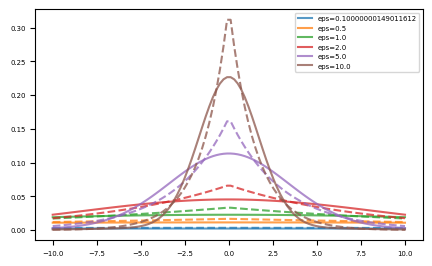

In [2]:
import matplotlib.pyplot as plt
from itertools import cycle

color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

plt.figure(figsize=(5, 3))

Delta = 150/10

eps_list = [0.1, 0.5, 1., 2., 5., 10.]

for eps in eps_list:

    eps = torch.tensor(eps)

    b = Delta/eps
    pi, mu1, mu2, sigma1, sigma2, _ = fit_laplace(torch.tensor(0.), b)

    program = 'v = gm([_p1, _p2], [_mean1, _mean2], [_sigma1, _sigma2]);'

    compiledFile=compile2SOGA_text(program)
    cfg = produce_cfg_text(compiledFile)

    pars = {'p1': pi,
            'p2': 1-pi,
            'mean1': mu1,
            'mean2': mu2,
            'sigma1': sigma1,
            'sigma2': sigma2}
    params_dict = {}
    for key, value in pars.items():
        params_dict[key] = torch.tensor(value, requires_grad=True)    

    dist = start_SOGA(cfg, params_dict=params_dict)

    x = torch.linspace(-10, 10, 100).reshape(100, 1)
    y = dist.gm.pdf(x).detach().numpy()
    y_lap = Laplace(0., b).log_prob(x).exp().detach().numpy()

    color = next(color_cycle)
    plt.plot(x, y_lap, '--', color=color, alpha=0.75)
    plt.plot(x, y, label='eps={}'.format(eps.item()), color=color, alpha=0.75)

plt.legend(fontsize=5)
plt.tick_params(axis='x', labelsize=5)
plt.tick_params(axis='y', labelsize=5)
plt.show()


In [3]:
torch.manual_seed(100)

In [4]:
Delta = 150./10.
eps_list = torch.tensor([0.1, 0.5, 1., 2., 5., 10.])

gvd_lap_lb = {}
gvd_lap_ub = {}
gvg_lap_lb = {}
gvg_lap_ub = {}

gvd_lap = {}
gvg_lap = {}

cond_entropy_lap_lb = {}
cond_entropy_lap_ub = {}
cond_entropy_lap = {}

mi_lap_lb = {}
mi_lap_ub = {}
mi_lap = {}

kl_lap_lb = {}
kl_lap_ub = {}
kl_lap = {}

# TO DO: compute confidence interval
#gvd_lap_ci = {}
#gvg_lap_ci  = {}
#cond_entropz_lap_ci = {}
#mi_lap_ci = {}
#kl_lap_ci = {}

sampling_time = 0.
bounds_time = 0.

for eps in eps_list:

    n_samples = 100_000

    print('n Eps: ', eps)

    # Approximating the Laplace
    b = Delta/eps

    print('b:', b)

    pi, mu1, mu2, sigma1, sigma2, _ = fit_laplace(torch.tensor(0.), b)

    
    pars = {'p1': pi,
            'p2': 1-pi,
            'mean1': mu1,
            'mean2': mu2,
            'sigma1': sigma1,
            'sigma2': sigma2}
    params_dict = {}
    for key, value in pars.items():
        params_dict[key] = torch.tensor(value, requires_grad=True)    

    # Computing SOGA outputs
    compiledFile=compile2SOGA('DP_Laplace.soga')
    cfg = produce_cfg(compiledFile)
    output_dist = start_SOGA(cfg, params_dict=params_dict)

    compiledFile=compile2SOGA('DP_Laplace_obs.soga')
    cfg = produce_cfg(compiledFile)
    output_dist_obs = start_SOGA(cfg, params_dict=params_dict)

    # Extracting marginals
    marg_lap = extract_marginal(output_dist, ['dataset[0]', 'avg'])
    marg_lap = aggregate_mixture(marg_lap)
    s_marg = extract_marginal(output_dist, ['dataset[0]'])
    s_marg = aggregate_mixture(s_marg)
    s_marg_obs = extract_marginal(output_dist_obs, ['dataset[0]'])
    s_marg_obs = aggregate_mixture(s_marg_obs)

    # Computes bounds
    start = time()
    gvd_lap_lb['{}'.format(eps)] = vdelta_lower_bound(marg_lap, idx_o=1)
    gvd_lap_ub['{}'.format(eps)] = vdelta_upper_bound(marg_lap, idx_o=1)
    gvg_lap_lb['{}'.format(eps)] = vgauss_lower_bound(marg_lap, 1., idx_o=1)
    gvg_lap_ub['{}'.format(eps)] = vgauss_upper_bound(marg_lap, 1., idx_o=1)

    cond_entropy_lap_lb['{}'.format(eps)] = cond_entropy_lb(marg_lap, idx_o=[1])
    cond_entropy_lap_ub['{}'.format(eps)] = cond_entropy_ub(marg_lap, idx_o=[1])
    
    mi_lap_lb['{}'.format(eps)] = mi_lb(marg_lap, idx_o=[1])
    mi_lap_ub['{}'.format(eps)] = mi_ub(marg_lap, idx_o=[1])

    kl_lap_lb['{}'.format(eps)] = kl_div_lb(s_marg_obs, s_marg)
    kl_lap_ub['{}'.format(eps)] = kl_div_ub(s_marg_obs, s_marg)
    end = time()
    bounds_time += end - start

    # Computes exact values via MCMC
    start = time()
    gvd_lap['{}'.format(eps)] = sample_gvuln(output_dist, n_samples, gain_type='delta', secret_var='dataset[0]', output_var='avg')
    gvg_lap['{}'.format(eps)] = sample_gvuln(output_dist, n_samples, gain_type='gauss', secret_var='dataset[0]', output_var='avg')
    
    cond_entropy_lap['{}'.format(eps)] = sample_cond_entropy(marg_lap, idx_o=[1], n_samples=n_samples)
    
    mi_lap['{}'.format(eps)] = sample_mi(marg_lap, idx_o=[1], n_samples=n_samples)
    
    kl_lap['{}'.format(eps)] = sample_kl(s_marg_obs, s_marg, n_samples)
    end = time()
    sampling_time += end - start

print('Bounds time: ', bounds_time)
print('Sampling time: ', sampling_time)

    
    

n Eps:  tensor(0.1000)
b: tensor(150.)
n Eps:  tensor(0.5000)
b: tensor(30.)
n Eps:  tensor(1.)
b: tensor(15.)
n Eps:  tensor(2.)
b: tensor(7.5000)
n Eps:  tensor(5.)
b: tensor(3.)
n Eps:  tensor(10.)
b: tensor(1.5000)
Bounds time:  0.17105889320373535
Sampling time:  19.408690214157104


In [6]:
print('G-Vulnerability (Delta Gain)')
for key in gvd_lap_lb.keys():
    print('\t Eps = {:.1f}, lb = {:.6f}, exact={:.6f}, ub= {:.6f}'.format(float(key), gvd_lap_lb[key], gvd_lap[key], gvg_lap_ub[key]))

print('\n G-Vulnerability (Gauss Gain)')
for key in gvg_lap_ub.keys():
    print('\t Eps = {:.1f}, lb = {:.6f}, exact={:.6f}, ub= {:.6f}'.format(float(key), gvg_lap_lb[key], gvg_lap[key], gvg_lap_ub[key]))

print('\n Conditional Entropy   ')
for key in cond_entropy_lap_ub.keys():
    print('\t Eps = {:.1f}, lb = {:.6f}, exact={:.6f}, ub= {:.6f}'.format(float(key), cond_entropy_lap_lb[key], cond_entropy_lap[key], cond_entropy_lap_ub[key]))

print('\n Mutual Information   ')
for key in mi_lap_ub.keys():
    print('\t Eps = {:.1f}, lb = {:.6f}, exact={:.6f}, ub= {:.6f}'.format(float(key), mi_lap_lb[key], mi_lap[key], mi_lap_ub[key]))

print('\n KL Divergence   ')
for key in kl_lap_ub.keys():
    print('\t Eps = {:.1f}, lb = {:.6f}, exact={:.6f}, ub= {:.6f}'.format(float(key), kl_lap_lb[key], kl_lap[key], kl_lap_ub[key]))

G-Vulnerability (Delta Gain)
	 Eps = 0.1, lb = 0.018647, exact=0.019948, ub= 0.049941
	 Eps = 0.5, lb = 0.018678, exact=0.019978, ub= 0.050018
	 Eps = 1.0, lb = 0.018763, exact=0.020058, ub= 0.050232
	 Eps = 2.0, lb = 0.018993, exact=0.020252, ub= 0.050813
	 Eps = 5.0, lb = 0.019419, exact=0.020729, ub= 0.051910
	 Eps = 10.0, lb = 0.019583, exact=0.020911, ub= 0.052376

 G-Vulnerability (Gauss Gain)
	 Eps = 0.1, lb = 0.046683, exact=0.049941, ub= 0.049941
	 Eps = 0.5, lb = 0.046760, exact=0.050007, ub= 0.050018
	 Eps = 1.0, lb = 0.046972, exact=0.050215, ub= 0.050232
	 Eps = 2.0, lb = 0.047547, exact=0.050707, ub= 0.050813
	 Eps = 5.0, lb = 0.048610, exact=0.051832, ub= 0.051910
	 Eps = 10.0, lb = 0.049020, exact=0.052342, ub= 0.052376

 Conditional Entropy   
	 Eps = 0.1, lb = 3.884000, exact=4.401910, ub= 4.791784
	 Eps = 0.5, lb = 3.882195, exact=4.409653, ub= 4.790520
	 Eps = 1.0, lb = 3.877163, exact=4.407876, ub= 4.787081
	 Eps = 2.0, lb = 3.863141, exact=4.403840, ub= 4.778267
	

### Geometric Mechanism

In [9]:
# No Noise

compiledFile=compile2SOGA('DP_Geometric.soga')
cfg = produce_cfg(compiledFile)
dist = start_SOGA(cfg)

secret_var = 'dataset[0]'
output_var = 'count' 

discrete_V1(dist, secret_var, output_var)

tensor(0.6230)

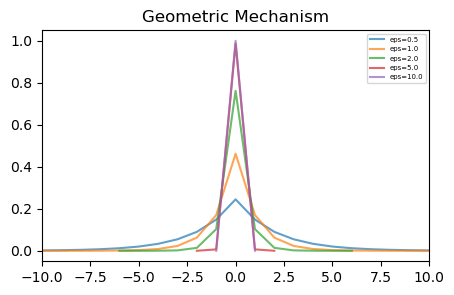

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3))

eps_list = [0.5, 1., 2., 5., 10.]

for eps in eps_list:

    Delta = torch.tensor(1.)
    p = 1-torch.exp(-eps/Delta)

    str_gm = create_gm_from_p(p)

    program = 'geom1 = {}; \n geom2 = {}; \n geom = geom1 - geom2;'.format(str_gm, str_gm)

    compiledFile=compile2SOGA_text(program)
    cfg = produce_cfg_text(compiledFile)
    dist = start_SOGA(cfg)

    marg = extract_marginal(dist, ['geom'])

    x = torch.unique(marg.gm.mu[:, 0])
    y = torch.zeros_like(x)
    for i in range(len(x)):
        mask = (marg.gm.mu[:, 0] == x[i])
        y[i] = torch.sum(marg.gm.pi[mask])

    # Plot the PMF
    plt.plot(x, y, alpha=0.7, label='eps={}'.format(eps))

plt.title(f'Geometric Mechanism')
plt.xlim(-10,10)
plt.legend(fontsize=5)
plt.show()



In [11]:
eps_list = torch.tensor([0.5, 1., 2., 5., 10.])

gv_geom = {}
entropy_geom = {}
cond_entropy_geom = {}
mi_geom = {}
kl_geom = {}


for eps in eps_list:

    print('Eps: ', eps)

    # Approximating the geometric in the program
    Delta = torch.tensor(1.)
    p = 1 - torch.exp(-eps/Delta)
    gm_str = create_gm_from_p(p)

    print('p:', p)

    program = '''array[10] dataset;

                for i in range(10){{
                    dataset[i] = gm([0.5,0.5], [0., 1.], [0.0, 0.0]);
                }} end for;
                count = 0.0;

                for i in range(10){{
                    count = count + dataset[i];
                }} end for;

                geom1 = {};
                geom2 = {}; 
                noise = geom1 - geom2;

                count = count + noise;
                '''.format(gm_str, gm_str)

    # computing SOGA outputs
    compiledFile = compile2SOGA_text(program)
    cfg = produce_cfg_text(compiledFile)
    output_dist = start_SOGA(cfg)
    #output_dist = aggregate_mixture(output_dist)

    program_obs = program + '\n observe(count == 2.);'
    compiledFile = compile2SOGA_text(program_obs)
    cfg = produce_cfg_text(compiledFile)
    output_dist_obs = start_SOGA(cfg)
    #output_dist_obs = aggregate_mixture(output_dist_obs)

    marg = extract_marginal(output_dist, ['dataset[0]'])
    marg = aggregate_mixture(marg)
    marg_obs = extract_marginal(output_dist_obs, ['dataset[0]'])
    marg_obs = aggregate_mixture(marg_obs)

    # Computing metrics
    gv_geom['{}'.format(eps)] = discrete_V1(output_dist, secret_var, output_var)    
    cond_entropy_geom['{}'.format(eps)] = discrete_cond_entropy(output_dist, secret_var, output_var)
    mi_geom['{}'.format(eps)] = discrete_mi(output_dist, secret_var, output_var)
    kl_geom['{}'.format(eps)] = discrete_kl(marg_obs, marg, secret_var)


Eps:  tensor(0.5000)
p: tensor(0.3935)
Eps:  tensor(1.)
p: tensor(0.6321)
Eps:  tensor(2.)
p: tensor(0.8647)
Eps:  tensor(5.)
p: tensor(0.9933)
Eps:  tensor(10.)
p: tensor(1.0000)


In [15]:
print('G-Vulnerability  ')
for key in gv_geom.keys():
    print('\t Eps = {:.1f},exact={:.6f}'.format(float(key), gv_geom[key]))


print('\n Conditional Entropy   ')
for key in cond_entropy_geom.keys():
    print('\t Eps = {:.1f}, exact = {:.6f}'.format(float(key), cond_entropy_geom[key]))

print('\n Mutual Information   ')
for key in mi_geom.keys():
    print('\t Eps = {:.1f}, exact = {:.6f}'.format(float(key), mi_geom[key]))

print('\n KL Divergence   ')
for key in kl_geom.keys():
    print('\t Eps = {:.1f}, exact = {:.6f}'.format(float(key), kl_geom[key]))



G-Vulnerability  
	 Eps = 0.5,exact=0.573904
	 Eps = 1.0,exact=0.600151
	 Eps = 2.0,exact=0.616569
	 Eps = 5.0,exact=0.622768
	 Eps = 10.0,exact=0.623045

 Conditional Entropy   
	 Eps = 0.5, exact = 0.678622
	 Eps = 1.0, exact = 0.662551
	 Eps = 2.0, exact = 0.647439
	 Eps = 5.0, exact = 0.640474
	 Eps = 10.0, exact = 0.640124

 Mutual Information   
	 Eps = 0.5, exact = 0.014525
	 Eps = 1.0, exact = 0.030596
	 Eps = 2.0, exact = 0.045709
	 Eps = 5.0, exact = 0.052674
	 Eps = 10.0, exact = 0.053024

 KL Divergence   
	 Eps = 0.5, exact = 0.024309
	 Eps = 1.0, exact = 0.072741
	 Eps = 2.0, exact = 0.145760
	 Eps = 5.0, exact = 0.190451
	 Eps = 10.0, exact = 0.192728
